In [ ]:
from transformers import AutoModel, AutoTokenizer
import numpy as np

model = AutoModel.from_pretrained('julien-c/bert-xsmall-dummy')
tokenizer = AutoModel.from_pretrained('julien-c/bert-xsmall-dummy')

In [1]:
import os
os.chdir('/home/david/Documents/PhD/old_src/sts_bert/sBERT')

In [2]:
from Percolation import make_percolation_dataset, PercolationTrainer, NN_one_hidden
train_set = make_percolation_dataset(n_examples=10000)
dev_set = make_percolation_dataset(n_examples=10000)
test_set = make_percolation_dataset(n_examples=1000)

0.5031
0.479
0.482


In [3]:
import torch
from ActiveLearning.ALDataLoader import ALDataLoader

batch_size = 32
train_dl = ALDataLoader(train_set, batch_size=batch_size, shuffle_train=True)
train_dl.select_k_at_random(1000)
dev_dl = torch.utils.data.DataLoader(dev_set, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
trainer = PercolationTrainer(train_dl, dev_dl, test_dl)

Scheduler type: constant_with_warmup, epochs: 10, steps per epoch: 313, total steps: 3130, warmup steps: 0


In [4]:
k = 250
times = 20
n_epochs = 20

batch_size = 32
original_model = NN_one_hidden()
original_model = None
dev_dl = torch.utils.data.DataLoader(dev_set, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0


NameError: name 'np' is not defined

In [5]:
import numpy as np

def run_experiment(mode='lc'):
    train_dl = ALDataLoader(train_set, batch_size=batch_size, shuffle_train=True)
    train_dl.select_k_at_random(k)

    training_progresses = []
    dev_performances = []

    for i in range(times):
        trainer = PercolationTrainer(train_dl, dev_dl, None, load_model=original_model,
                                     n_epochs=n_epochs)
        train_dl.train()
        trainer.train(disable_progress_bar=True, verbose=False, eval_zero_shot=True,
                      early_stopping=False)
        training_progresses.append(trainer.training_progress)
        dev_performances.append(trainer.best_dev_performance)
        print('Dataloader size: {}, score: {}'.format(np.sum(train_dl.selected),
                                                      trainer.best_dev_performance))

        if mode == 'rnd':
            train_dl.select_k_at_random(k)
        else:
            train_dl.selection()
            probs, _ = trainer.predict(train_dl, disable_progress_bar=True)
            probs = np.expand_dims(np.array(probs), 1)
            confidences = np.concatenate((probs, 1 - probs), axis=1).max(axis=1)
            if mode == 'mc':
                confidences = -confidences
            else:
                assert mode == 'lc'
            lc_indices = np.argpartition(confidences, range(k))[:k]
            train_dl.select_indices(train_dl.selection_indices[lc_indices])

    return training_progresses, dev_performances

progress_lc, performance_lc = run_experiment(mode='lc')
progress_mc, performance_mc = run_experiment(mode='mc')
progress_rnd, performance_rnd = run_experiment(mode='rnd')

Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 250, score: 0.5564
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 500, score: 0.5701
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 750, score: 0.6094
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1000, score: 0.643
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1250, score: 0.6436
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1500, score: 0.6667
Scheduler type: constant_with_warmup, epochs: 20, steps per epoch: 313, total steps: 6260, warmup steps: 0
Dataloader size: 1750, score: 0.6

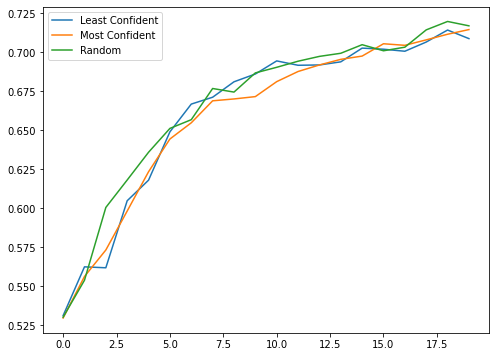

In [73]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [8, 6]
plt.plot(performance_lc, label='Least Confident')
plt.plot(performance_mc, label='Most Confident')
plt.plot(performance_rnd, label='Random')
plt.legend();

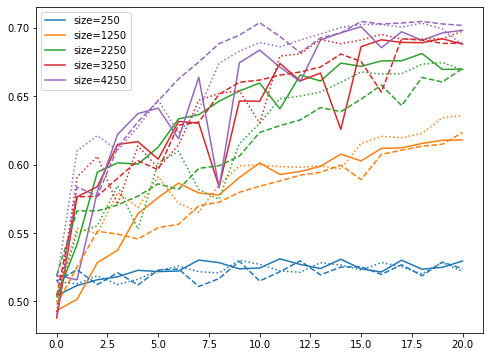

In [74]:
for i, tp in enumerate(progress_lc):
    if i%4 == 0:
        plt.plot(tp['dev_performance'], label='size={}'.format((i+1)*k), c='C{}'.format(i//4))
plt.legend();
for i, tp in enumerate(progress_mc):
    if i%4 == 0:
        plt.plot(tp['dev_performance'], label='size={}'.format((i+1)*k), linestyle='--', c='C{}'
                 .format(i//4))
for i, tp in enumerate(progress_rnd):
    if i%4 == 0:
        plt.plot(tp['dev_performance'], label='size={}'.format((i+1)*k), linestyle=':', c='C{}'
                 .format(i//4))


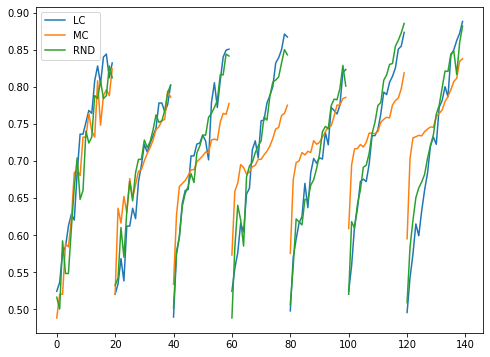

In [33]:
j = 0
for i in range(len(progress_lc)):
    if i + 1 in range(8):#[1, 2, 3, 5, 10, 20]:
        values = progress_lc[i]['dev_performance']
        plt.plot(range(n_epochs * j, n_epochs * j + len(values)), values, c='C0', label='LC')
        values = progress_mc[i]['dev_performance']
        plt.plot(range(n_epochs * j, n_epochs * j + len(values)), values, c='C1', label='MC')
        values = progress_rnd[i]['dev_performance']
        plt.plot(range(n_epochs * j, n_epochs * j + len(values)), values, c='C2', label='RND')
        if j == 0:
            plt.legend();
        j += 1
